/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


window size is 2048
sample rate is 22050
time of audio is 23.4985941043
number of sampels is 518144
number of windows is 253
('step size in sampels is ', 512)


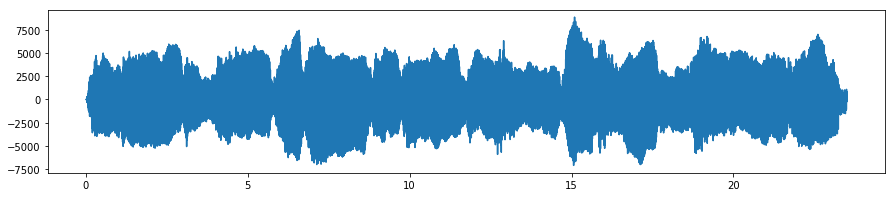

In [1]:
from scipy import signal
from scipy.io import wavfile #to read and write wavfiles
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import math
from matplotlib import style
from featureExtractionAspriya import short_term_feauture_extraction, stSpectralFlux
from spectralFeatureExtractionAspriya import stSpectogram
from recordAudioWhilePloting import record
from f0_detection import detect_f0
import pandas as pd
import seaborn as sns
import tensorflow as tf
# style.use('ggplot')


def record():
    fs = 44100
    data = record(rate=fs, chunk_size=1024, record_seconds=10)
    return fs, data

def generate_timeArray():
    # gives a array containing numbers from 1 to number of samples
    timeArray = np.arange(len(data));
    timeArray = timeArray / float(fs)   #convert to seconds
    # timeArray = timeArray * 1000 #scale to milliseconds
    return timeArray

fs, data = wavfile.read('onsetDetectionData/sounds/realorgan3.wav')
length_of_audio = len(data) / float(fs)
window = 'hanning'

#time signal graph
timeArray = generate_timeArray()

f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(timeArray, data)

#window_length_in_milliseconds = 92
#window_length_in_samples = (fs *window_length_in_milliseconds) / 1000
window_length_in_samples = 2048 #1024,2048,4096,8192
nperseg = window_length_in_samples
nfft = None #lenght of fft window. if zeor padding is neades, use a suitable power of 2 value here

print("window size is " + str(window_length_in_samples))
print("sample rate is " + str(fs))
print("time of audio is "+ str(length_of_audio))
print("number of sampels is "+ str(len(data)))
print("number of windows is "+ str(len(data)/window_length_in_samples))


step_size_in_samples = window_length_in_samples//4
print("step size in sampels is ", step_size_in_samples)

('length of f0 array : ', 1012)


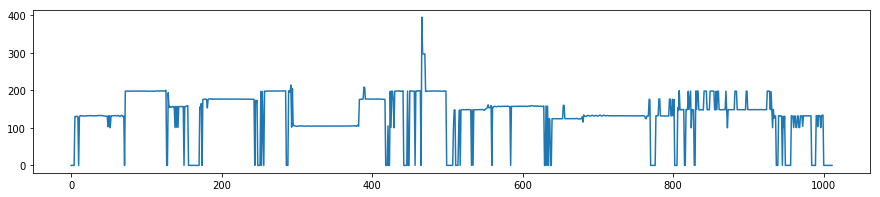

In [2]:
f0_array = detect_f0('onsetDetectionData/sounds/realorgan3.wav', 2048, 512)
print("length of f0 array : ", len(f0_array))
f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(f0_array);

feature matrix shape is: (7, 1009)
('number of frames : ', 1009)


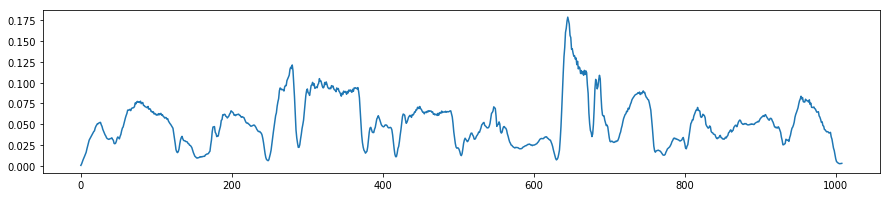

In [3]:
short_term_feautures, specgram, TimeAxis, FreqAxis = short_term_feauture_extraction(data, fs, window_length_in_samples, step_size_in_samples)
print ("feature matrix shape is: " +str(short_term_feautures.shape))

num_frames = len(short_term_feautures[0])
print("number of frames : ", num_frames)

# energy
f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(short_term_feautures[1])


('len short_term_features[1] : ', 1009)
('short_term_features[0] type : ', <type 'numpy.ndarray'>)


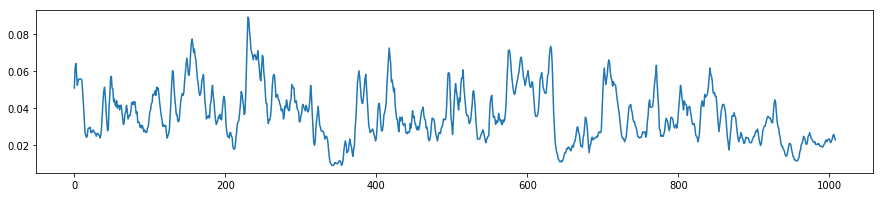

In [4]:
# Zero Crossing rate
f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(short_term_feautures[0])
print("len short_term_features[1] : ", len(short_term_feautures[1]))
print("short_term_features[0] type : ", type(short_term_feautures[0]))

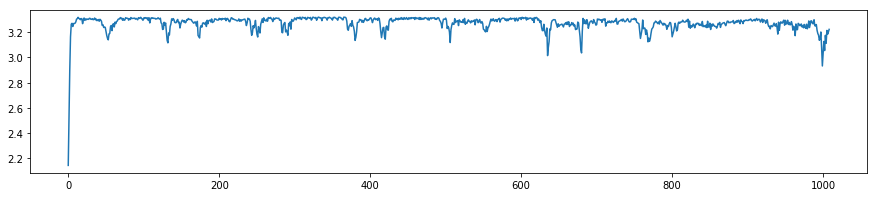

In [5]:
# energy entropy
f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(short_term_feautures[2])

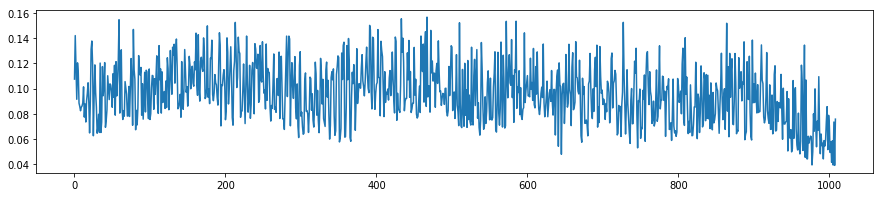

In [6]:
# Spectral centroid
f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(short_term_feautures[3])

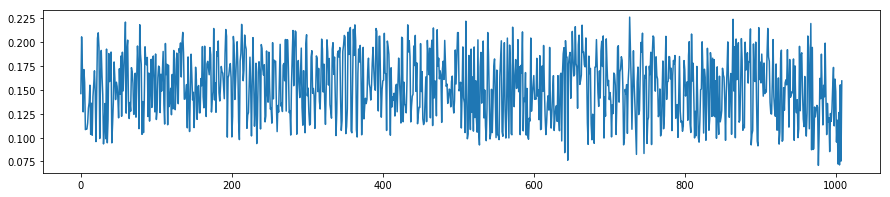

In [7]:
# Spectral spread
f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(short_term_feautures[4])

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:7235: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


('spectogram length ', 1009)
('spectrogram shape ', (1009, 1024))


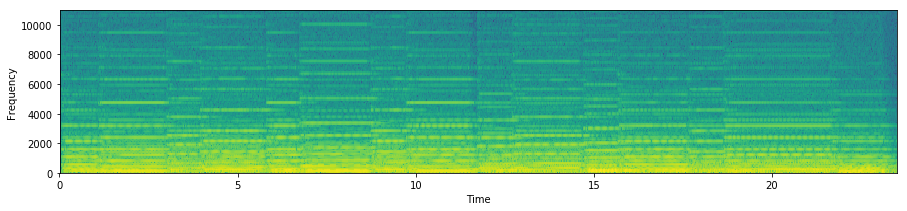

In [8]:
f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.specgram(data, Fs=fs)
plt.xlabel('Time')
plt.ylabel('Frequency')

# print("spectrogram is: ",  specgram)
print("spectogram length ", len(specgram))
print("spectrogram shape ", specgram.shape)

1004


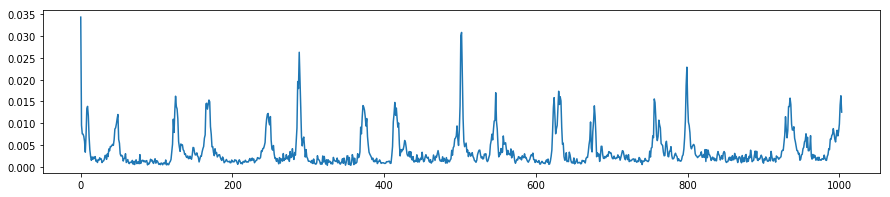

In [9]:
# calculate spectral flux between relevant frames
# Spectral flux is a measure of how quickly the power spectrum of a signal is changing, 
# calculated by comparing the power spectrum for one frame against the power spectrum from the previous frame
crnt_fram = 0
spectral_flux = []
while (crnt_fram < len(specgram)-5):
    fram_pair1 = specgram[crnt_fram]
    fram_pair2 = specgram[crnt_fram + 5]
    sp_flux = stSpectralFlux(fram_pair2, fram_pair1)
    spectral_flux.append(sp_flux)
    crnt_fram = crnt_fram + 1

f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(spectral_flux)
print(len(spectral_flux))

In [10]:
window_length_in_seconds = window_length_in_samples / float(fs)
step_size_in_seconds = step_size_in_samples / float(fs)

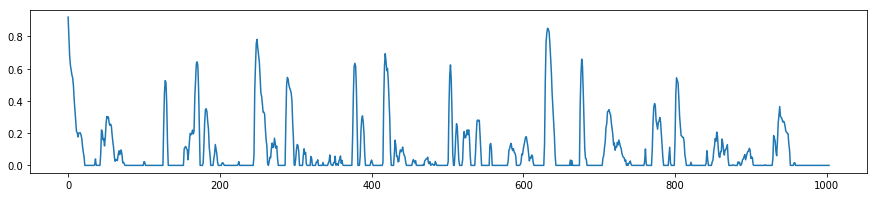

In [11]:
crnt_fram = 1
fram_pairs = []
frame1_time_array = []
while (crnt_fram <= len(short_term_feautures[0])):
    fram_pair1 = crnt_fram
    fram_pair2 = crnt_fram + 5
    if(fram_pair2 <= len(short_term_feautures[0])):
        fram_pairs.append([fram_pair1, fram_pair2])
        
    t1 = window_length_in_seconds + ((crnt_fram - 1) * step_size_in_seconds )
    frame1_time_array.append(t1)
    crnt_fram = crnt_fram + 1


df2 = pd.DataFrame(fram_pairs, columns=['frame 1', 'frame 2'])
df2['f1 end time'] = pd.Series(frame1_time_array)

df2['f1_ZCR'] = pd.Series(short_term_feautures[0][:num_frames-5])
df2['f2_ZCR'] = pd.Series(short_term_feautures[0][5:])

df2['f1_Energy'] = pd.Series(short_term_feautures[1][:num_frames-5])
df2['f2_Energy'] = pd.Series(short_term_feautures[1][5:])

#calculate energy change ratio
crnt_fram = 0
e_change_ratio = []
while (crnt_fram < len(df2['f1_Energy'])):
    f1_en = df2['f1_Energy'].iloc[crnt_fram]
    f2_en = df2['f2_Energy'].iloc[crnt_fram]
    
    delta_e = f2_en - f1_en
    if(delta_e > 0):
        e_change_ratio.append(delta_e / max(f1_en, f2_en))
    else:
        e_change_ratio.append(0 / max(f1_en, f2_en))    
    crnt_fram = crnt_fram + 1
    
df2['E change Ratio'] = pd.Series(e_change_ratio) #insert energy change ration to data frame

#plot energy change ratio
f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(df2['E change Ratio'])

In [12]:
    
# df2['f1_Energy Entropy'] = pd.Series(short_term_feautures[2][:num_frames-5])
# df2['f2_Energy Entropy'] = pd.Series(short_term_feautures[2][5:])

df2['spectral centroid'] = pd.Series(short_term_feautures[3][:num_frames-5])
# df2['spectral spread'] = pd.Series(short_term_feautures[4][:num_frames-5])
df2['spectral entropy'] = pd.Series(short_term_feautures[5][:num_frames-5])
df2['spectral rolloff'] = pd.Series(short_term_feautures[6][:num_frames-5])

df2['spectral flux'] = pd.Series(spectral_flux)
df2.describe()

,frame 1,frame 2,f1 end time,f1_ZCR,f2_ZCR,f1_Energy,f2_Energy,E change Ratio,spectral centroid,spectral entropy,spectral rolloff,spectral flux
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,502.500000,507.500000,11.737687,0.036493,0.036329,0.053068,0.053057,0.091228,0.096065,0.297126,0.052972,0.003643
std,289.974137,289.974137,6.733186,0.014214,0.014157,0.027857,0.027875,0.163640,0.022888,0.162038,0.025397,0.003882
min,1.000000,6.000000,0.092880,0.009282,0.009282,0.000973,0.002996,0.000000,0.039248,0.019566,0.013672,0.000373
25%,251.750000,256.750000,5.915283,0.025892,0.025403,0.032517,0.032517,0.000000,0.078866,0.169497,0.036133,0.001419
50%,502.500000,507.500000,11.737687,0.034441,0.034196,0.049688,0.049688,0.000000,0.095038,0.289883,0.047852,0.002239
75%,753.250000,758.250000,17.560091,0.045432,0.045066,0.066208,0.066208,0.113369,0.111830,0.402262,0.064453,0.003978
max,1004.000000,1009.000000,23.382494,0.088911,0.088911,0.178255,0.178255,0.919300,0.156707,0.920506,0.169922,0.034265


In [13]:
print(short_term_feautures[1][:7])
print(df2.f2_Energy.describe())

[0.00097293 0.00278922 0.00530504 0.00782389 0.00985851 0.0120562
 0.01428551]
count    1004.000000
mean        0.053057
std         0.027875
min         0.002996
25%         0.032517
50%         0.049688
75%         0.066208
max         0.178255
Name: f2_Energy, dtype: float64


In [14]:

#............ GET CSV AND PREPARING ONSET ARRAY (WETHER A ONSET DETECTED OR NOT AT THAT TIME INTERVAL) ...........
# Length of onset array should be number of frames - 5 (since the step size is "window_length_in_samples / 4")

def get_onset_lables():
    df = pd.read_csv('onsetDetectionData/ground-truth/realorgan3.txt', header=None)
    df.columns = ['time']
    #df.head()
    
    crnt_fram = 1
    onsetArray = []
    print(" ")
    print("-----------------------------------------------------------")
    print("window length in seconds : ", window_length_in_seconds)
    print("step size in seconds : ", step_size_in_seconds)

    while (crnt_fram <= len(short_term_feautures[0]) - 5):
        t1 = window_length_in_seconds + ((crnt_fram - 1) * step_size_in_seconds )
        t2 = t1 + step_size_in_seconds
        #if t is in between t1 and t2, push 1 to onsetArray, else push 0.
        if(len(df[df.time > t1][df.time < t2]) > 0):
             onsetArray.append(1)
        else:
             onsetArray.append(0)

        crnt_fram = crnt_fram + 1

    df2['onset'] = pd.Series(onsetArray)
    df2.head(10)

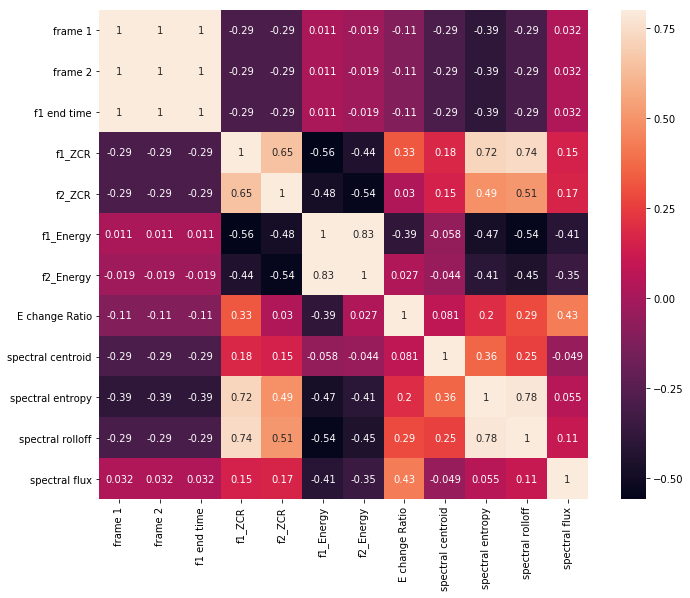

In [15]:
#correlation matrix
corrmat = df2.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

In [16]:
#call this function to prepare the labels. this needs to be called only when training. so comment when predictin
get_onset_lables()

 
-----------------------------------------------------------
('window length in seconds : ', 0.09287981859410431)
('step size in seconds : ', 0.023219954648526078)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


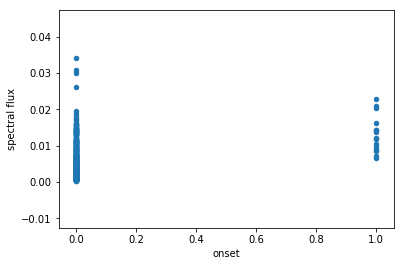

In [17]:
# Lets check individual attributes with onset
if 'onset' in df2.columns:
    df2[['onset', 'spectral flux']].plot.scatter(x='onset', y='spectral flux')

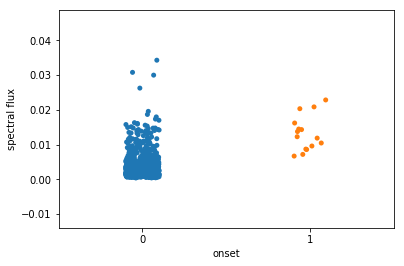

In [18]:
# In a strip plot, the scatterplot points will usually overlap. This makes it difficult to see the full 
# distribution of data. One easy solution is to adjust the positions (only along the categorical axis) 
# using some random “jitter”:
# sns.stripplot(x="categorical attribute", y="other attribute", jitter=True);
if 'onset' in df2.columns:
    sns.stripplot(x=df2["onset"], y=df2["spectral flux"], jitter=True)

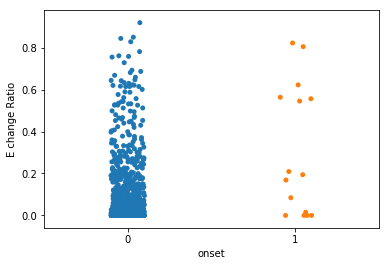

In [19]:
#onset vs Energy change ratio
if 'onset' in df2.columns:
    sns.stripplot(x=df2["onset"], y=df2["E change Ratio"], jitter=True)

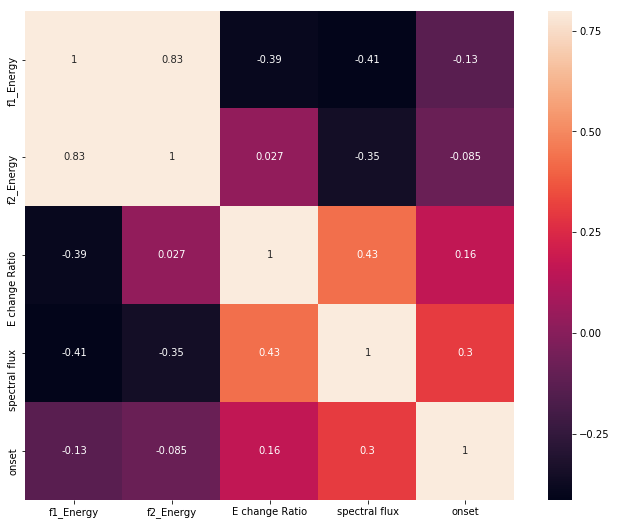

In [20]:
#drop some column from the dataframe and create the data frame with training features

#Note that id 0 = farme 1 and frame 6, id 1 = frame 2 and frame 7 and so on. (this is needed after getting results)
d_lst=['frame 1','frame 2','spectral entropy','spectral rolloff','f1 end time','spectral centroid','f1_ZCR','f2_ZCR']
df3 = df2.drop(d_lst, axis = 1) #not inplace=true. because we might want original df

if 'onset' in df2.columns: # just plot only if onset is there, when predicting we don't want plot this
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(df3.corr(), vmax=.8, square=True, annot=True);

In [21]:
df3.head()

,f1_Energy,f2_Energy,E change Ratio,spectral flux,onset
0,0.000973,0.012056,0.919300,0.034265,0
1,0.002789,0.014286,0.804752,0.009569,1
2,0.005305,0.016636,0.681113,0.007591,0
3,0.007824,0.020641,0.620953,0.007532,0
4,0.009859,0.024010,0.589407,0.007017,0


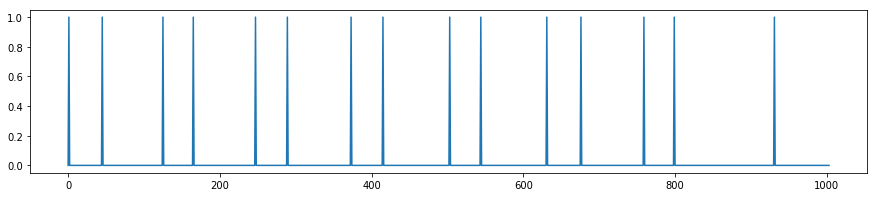

In [22]:
f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(df3['onset'])

('length of f0 array : ', 1012)


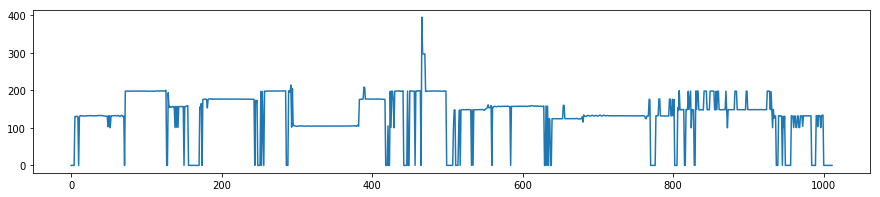

In [23]:
f0_array = detect_f0('onsetDetectionData/sounds/realorgan3.wav', 2048, 512)
print("length of f0 array : ", len(f0_array))
f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
plt.plot(f0_array);

In [24]:
## 4th PHASE -- BUILD THE MODEL

#placeholders
x = tf.placeholder(tf.float32, shape=[None, 4])
y = tf.placeholder(tf.float32, shape=[None, 1])

#settings
batch_size = 30
layer1_nodes = 100
layer2_nodes = 100
layer3_nodes = 50
layer4_nodes = 50
output_nodes = 1
num_epochs = 200

#model
def model(x):
    layer_1={
        'weights': tf.Variable(tf.random_normal([4, layer1_nodes])),
        'bias': tf.Variable(tf.random_normal([layer1_nodes]))
    }
    
    layer_2={
        'weights': tf.Variable(tf.random_normal([layer1_nodes, layer2_nodes])),
        'bias': tf.Variable(tf.random_normal([layer2_nodes]))
    }
    
    layer_3={
        'weights': tf.Variable(tf.random_normal([layer2_nodes, layer3_nodes])),
        'bias': tf.Variable(tf.random_normal([layer3_nodes]))
    }
    
    layer_4={
        'weights': tf.Variable(tf.random_normal([layer3_nodes, layer4_nodes])),
        'bias': tf.Variable(tf.random_normal([layer4_nodes]))
    }
    
    output_layer={
        'weights': tf.Variable(tf.random_normal([layer4_nodes, output_nodes])),
        'bias': tf.Variable(tf.random_normal([output_nodes]))
    }
    
    operation_layer1 = tf.add(tf.matmul(x, layer_1['weights']), layer_1['bias'])
    operation_layer1 = tf.nn.relu(operation_layer1)
    
    operation_layer2 = tf.add(tf.matmul(operation_layer1, layer_2['weights']), layer_2['bias'])
    operation_layer2 = tf.nn.relu(operation_layer2)
    
    operation_layer3 = tf.add(tf.matmul(operation_layer2, layer_3['weights']), layer_3['bias'])
    operation_layer3 = tf.nn.relu(operation_layer3)
    
    operation_layer4 = tf.add(tf.matmul(operation_layer3, layer_4['weights']), layer_4['bias'])
    operation_layer4 = tf.nn.relu(operation_layer4)
    
    operation_output_layer = tf.add(tf.matmul(operation_layer4, output_layer['weights']), output_layer['bias'])
    return operation_output_layer


In [25]:
## 5th PHASE -- TRAIN
import math

def train(x):
    
    Y = np.array(df3.onset.values)
    Y = Y.reshape(len(df3.axes[0]), 1)
    X = df3.drop(['onset'], axis = 1).values
    print("shape X - "+str(X.shape)+"  Y shape-"+str(Y.shape))
    
    #Y = Y.reshape(1457, 1)
    #split data for training and testing
    split_size = int(0.80 * len(Y)) #when doing final training make int(1 * len(Y)) 
    train_x = X[:split_size]
    train_y = Y[:split_size]
    test_x = X[split_size:]
    test_y = Y[split_size:]

    #get model output. this is not prediction in logistic regression. we need put to sigmoid to get prediction
    from_model = model(x)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=from_model, labels=y))
    optimizer = tf.train.GradientDescentOptimizer(0.0023).minimize(loss)
    
    # Define the accuracy
    # The default threshold is 0.5, rounded off directly
    prediction = tf.round(tf.sigmoid(from_model))
    correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32)
    accuracy = tf.reduce_mean(correct) # Average
    
    #save file location and Saver object
    save_file = './models/onsetDetector_train_model.ckpt'
    saver = tf.train.Saver()
    
    # Define arrays that storo the results
    epoch_loss_trace = []
    train_accu = []
    test_accu = []
    
    #start a session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(num_epochs):
            epoch_loss = 0
            e_train_accu = 0
            e_test_accu = 0
  
            #handle batches
            i = 0
            j = 0
            while i < split_size:
                start = i
                end = i + batch_size
                batch_x = np.array(train_x[start:end])  
                batch_y = np.array(train_y[start:end])
                
                _, l = sess.run([optimizer, loss], feed_dict={x:batch_x, y:batch_y})               
                train_a = sess.run([accuracy], feed_dict={x:train_x, y:train_y})  
                test_a = sess.run([accuracy], feed_dict={x:test_x, y:test_y})  
                
                e_train_accu += train_a[0]
                e_test_accu += test_a[0]
                epoch_loss += l
                
                j = j + 1
                i += batch_size
            
            train_accu.append(e_train_accu / j)
            test_accu.append(e_test_accu / j)
            epoch_loss_trace.append(epoch_loss)
            
            if (epoch) % 5 == 0: #show results only 50 epochs at a time    
                print('Epoch',epoch, 'loss:',epoch_loss,'train_acc:',e_train_accu/j,'test_acc:',e_test_accu/j)
        
        saver.save(sess, save_file)
        print("Trained model saved")
    
    # Visualization of the results
    # loss function
    f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
    plt.plot(epoch_loss_trace)
    plt.title('Cross Entropy Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    # accuracy plots
    f, ax = plt.subplots(figsize=(15, 3)) #figsize=(width, height)
    plt.plot(train_accu, 'b-', label='train accuracy')
    plt.plot(test_accu, 'k-', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Train and Test Accuracy')
    plt.legend(loc='best')
    plt.show()


In [26]:
prediction_array =[]
def predict(x):
    X = df3.values #convert to numpy.ndarray
    print("shape of X is-" + str(X.shape))
    from_model = model(x) # operation to get model output using the trained model.
    prediction = tf.round(tf.sigmoid(from_model))
    
    #saved file location to retriev Saver object
    save_file = './models/onsetDetector_train_model.ckpt'
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        saver.restore(sess, save_file)
        
        j = 1
        while j <= len(X):
            predict = sess.run(prediction, feed_dict={x: X[j-1:j]})
            prediction_array.append(predict[0].item())
            print("frame: ", j, " prediction: ", predict[0][0])
            j += 1
    
    plt.plot(prediction_array)
    
    
    

In [27]:
# train(x)
# predict(x)

In [28]:
# df3['onset'] = pd.Series(prediction_array)
# df3.head(100)